<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/BNL_Scripts/Topas_Fits_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Topas Fits Analysis

*Analyzes fitted data parameters from Topas.*

##Imports

In [1]:
from google.colab import drive  #allows downloading and accessing files on drive
from google.colab import files  #allows downloading and accessing files on drive
import shutil                   #allows uploading files to drive
import glob                     #useful for collecting and organizing files
import csv
import numpy as np              #math library
import pandas as pd             #data organization library
import scipy as sp              #math library
from scipy import optimize      #math fitting library
import matplotlib.pylab as plt  #allows for plotting
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Extract Data from Google Drive

In [2]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# Directory Locations for information
Topas_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/CeO2_PDF_600_1sec/integration/'
temp_path = '/content/drive/Shareddrives/BNL_June_2024/DataFiles/CeO2_PDF_600_1sec/scalar_data/'
#tth_files = glob.glob(directory_path + '/*tth.xy')

In [23]:
# Read in and convert temperature data to floats
temp_file = temp_path+"CeO2_PDF_600_1sec_20240612-112457_67ac61_primary.csv"
temp_data = pd.read_csv(temp_file)
temp_data = temp_data.astype(float)
temp_data = temp_data.sort_values(by='time')
# Read in and convert fitted lattice parameters to floats
data_file = Topas_path+"Fit_results.txt"
data = pd.read_csv(data_file, header=None)
data = data[data.columns[0]].str.split('\s+', expand=True)
data[data.columns[0]] = data[data.columns[0]].str.split("_",expand=True)[6].str.split("-",expand=True)[1].astype(int)
data = data.astype(float)
data.columns = ["FileName", "r_wp", "lp", "lp_error"]
data = data.sort_values(by = 'FileName').reset_index(drop=True)
# Combine temperature and lattice parameter data, carefully ensuring the right temperature corresponds to the correct lattice parameter
data1 = pd.concat([data,temp_data],axis=1).drop(['pe1_stats1_total', 'eurotherm_power', 'chi_argmax', 'gr_max', 'gr_argmax', 'chi_max'], axis=1)  # add column headers
data1["delta_lp"] = data["lp"] - data1.iloc[0,data1.columns.get_loc("lp")]  # add column that has the change in the lattice parameter
data1['IR_temp'] = data1["eurotherm_temperature"]*1.34-22.4                 # convert eurotherm_temperature (control temp) to IR measured temp
data1["sample_temp"] = data1.iloc[0,data1.columns.get_loc("IR_temp")] + (data1["delta_lp"]/(1.13*10**(-5)*data1.iloc[0,data1.columns.get_loc("lp")])) # convert IR temp to sample temp using linear CeO2 thermal expansion
data1

,FileName,r_wp,lp,lp_error,time,eurotherm_temperature,seq_num,delta_lp,IR_temp,sample_temp
0,1.0,4.044,5.41138,0.00010,1.718206e+09,30.0,1.0,0.00000,17.80,17.800000
1,2.0,4.016,5.41140,0.00010,1.718206e+09,30.0,2.0,0.00002,17.80,18.127072
2,3.0,4.027,5.41140,0.00010,1.718206e+09,30.0,3.0,0.00002,17.80,18.127072
3,4.0,4.023,5.41139,0.00010,1.718206e+09,31.0,4.0,0.00001,19.14,17.963536
4,5.0,4.014,5.41143,0.00010,1.718206e+09,31.0,5.0,0.00005,19.14,18.617680
...,...,...,...,...,...,...,...,...,...,...
545,546.0,2.031,5.45024,0.00006,1.718206e+09,539.0,546.0,0.03886,699.86,653.301120
546,547.0,2.042,5.45026,0.00006,1.718206e+09,540.0,547.0,0.03888,701.20,653.628193
547,548.0,2.014,5.45005,0.00006,1.718206e+09,539.0,548.0,0.03867,699.86,650.193935
548,549.0,2.008,5.45006,0.00006,1.718206e+09,539.0,549.0,0.03868,699.86,650.357471


## Analyze Data

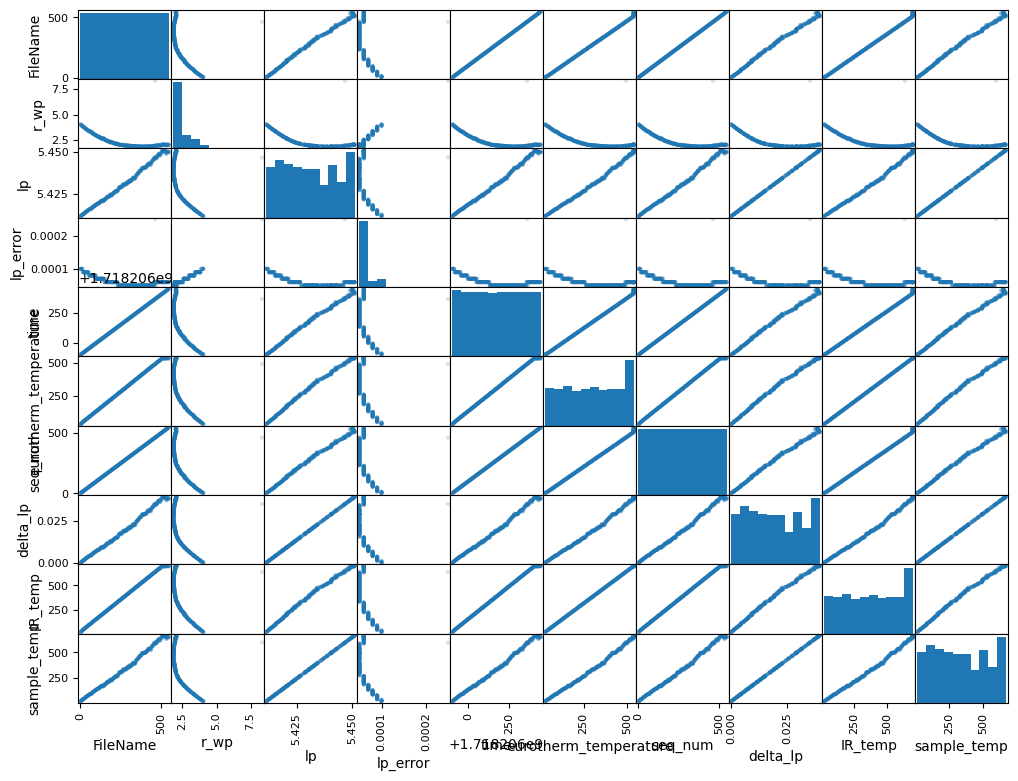

In [26]:
pd.plotting.scatter_matrix(data1, alpha=.2, figsize=(12,9));

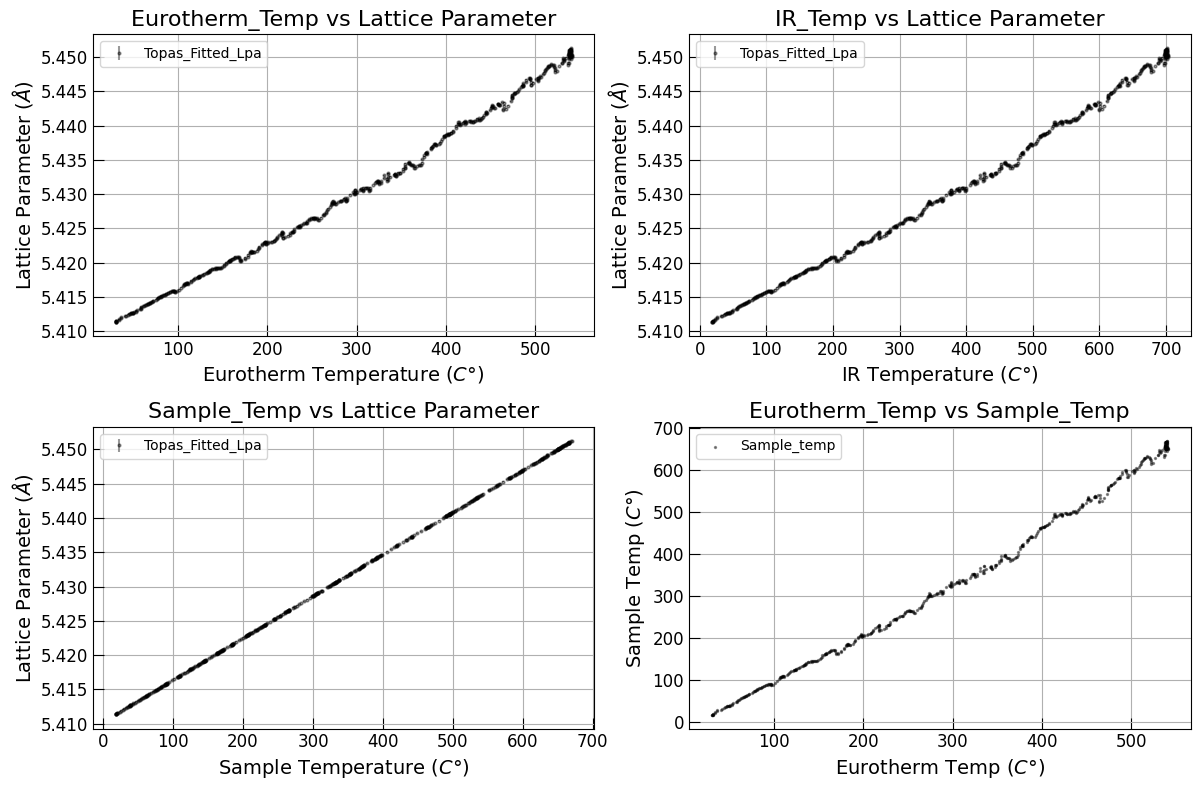

In [25]:
fig, axs = plt.subplots(2, 2,figsize=(12, 8))
# Plot settings
axs[0,0].errorbar(data1['eurotherm_temperature'],data1['lp'],yerr=data1['lp_error'], color='black', label = "Topas_Fitted_Lpa",fmt="o",markersize=2,alpha=.4)
axs[0,0].set_title('Eurotherm_Temp vs Lattice Parameter', fontsize=16)
axs[0,0].set_ylabel(r'Lattice Parameter $(\AA)$', fontsize=14)
axs[0,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,0].set_xlabel(r'Eurotherm Temperature $(C\degree)$', fontsize=14)
axs[0,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,0].legend()
axs[0,0].grid(True)
axs[0,0].set_axisbelow(True)

axs[0,1].errorbar(data1['IR_temp'],data1['lp'],yerr=data1['lp_error'], color='black', label = "Topas_Fitted_Lpa",fmt="o",markersize=2,alpha=.4)
axs[0,1].set_title('IR_Temp vs Lattice Parameter', fontsize=16)
axs[0,1].set_ylabel(r'Lattice Parameter $(\AA)$', fontsize=14)
axs[0,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[0,1].set_xlabel(r'IR Temperature $(C\degree)$', fontsize=14)
axs[0,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[0,1].legend()
axs[0,1].grid(True)
axs[0,1].set_axisbelow(True)

axs[1,0].errorbar(data1['sample_temp'],data1['lp'],yerr=data1['lp_error'], color='black', label = "Topas_Fitted_Lpa",fmt="o",markersize=2,alpha=.4)
axs[1,0].set_title('Sample_Temp vs Lattice Parameter', fontsize=16)
axs[1,0].set_ylabel(r'Lattice Parameter $(\AA)$', fontsize=14)
axs[1,0].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,0].set_xlabel(r'Sample Temperature $(C\degree)$', fontsize=14)
axs[1,0].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,0].legend()
axs[1,0].grid(True)
axs[1,0].set_axisbelow(True)

axs[1,1].scatter(data1['eurotherm_temperature'],data1['sample_temp'], color='black', label = "Sample_temp",alpha=.4, s=2)
axs[1,1].set_title('Eurotherm_Temp vs Sample_Temp', fontsize=16)
axs[1,1].set_ylabel(r'Sample Temp $(C\degree)$', fontsize=14)
axs[1,1].tick_params(axis='y', labelsize=12, direction='in', length=8)
axs[1,1].set_xlabel(r'Eurotherm Temp $(C\degree)$', fontsize=14)
axs[1,1].tick_params(axis='x', labelsize=12, direction='in', length=8)
axs[1,1].legend()
axs[1,1].grid(True)
axs[1,1].set_axisbelow(True)
plt.tight_layout()